In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('datasets/heart2.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [13]:
df.columns = df.columns.str.replace(' ', '')
df.rename(columns={'num': 'label'}, inplace=True)
df=df.replace('?',np.nan)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,28,1,2,130,132,0,2,185,0,0.0,NaN,NaN,NaN,0
1,29,1,2,120,243,0,0,160,0,0.0,NaN,NaN,NaN,0
2,29,1,2,140,NaN,0,0,170,0,0.0,NaN,NaN,NaN,0
3,30,0,1,170,237,0,1,170,0,0.0,NaN,NaN,6,0
4,31,0,2,100,219,0,1,150,0,0.0,NaN,NaN,NaN,0



# Understanding the Dataset

    - age (#)
    - sex : 1 = Male, 0 = Female (Binary)
    - (cp) chest pain [type (4 values, Ordinal)]: 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
    - (trestbps) resting blood pressure (#)
    - (chol) serum cholestoral in mg/dl (#)
    - (fbs) fasting blood sugar > 120 mg/dl (Binary) [1 = true; 0 = false]
    - (restecg) resting electrocardiographic results [values 0,1,2]
    - (thalach) maximum heart rate achieved (#)
    - (exang) exercise induced angina (Binary) [1 = yes; 0 = no]
    - (oldpeak) = ST depression induced by exercise relative to rest (#)
    - (slope) of the peak exercise ST segment (Ordinal) [ 1: upsloping, 2: flat , 3: downsloping)
    - (ca) number of major vessels (0-3, Ordinal) colored by fluoroscopy
    - (thal) maximum heart rate achieved (Ordinal) [3 = normal; 6 = fixed defect; 7 = reversable defect]



294

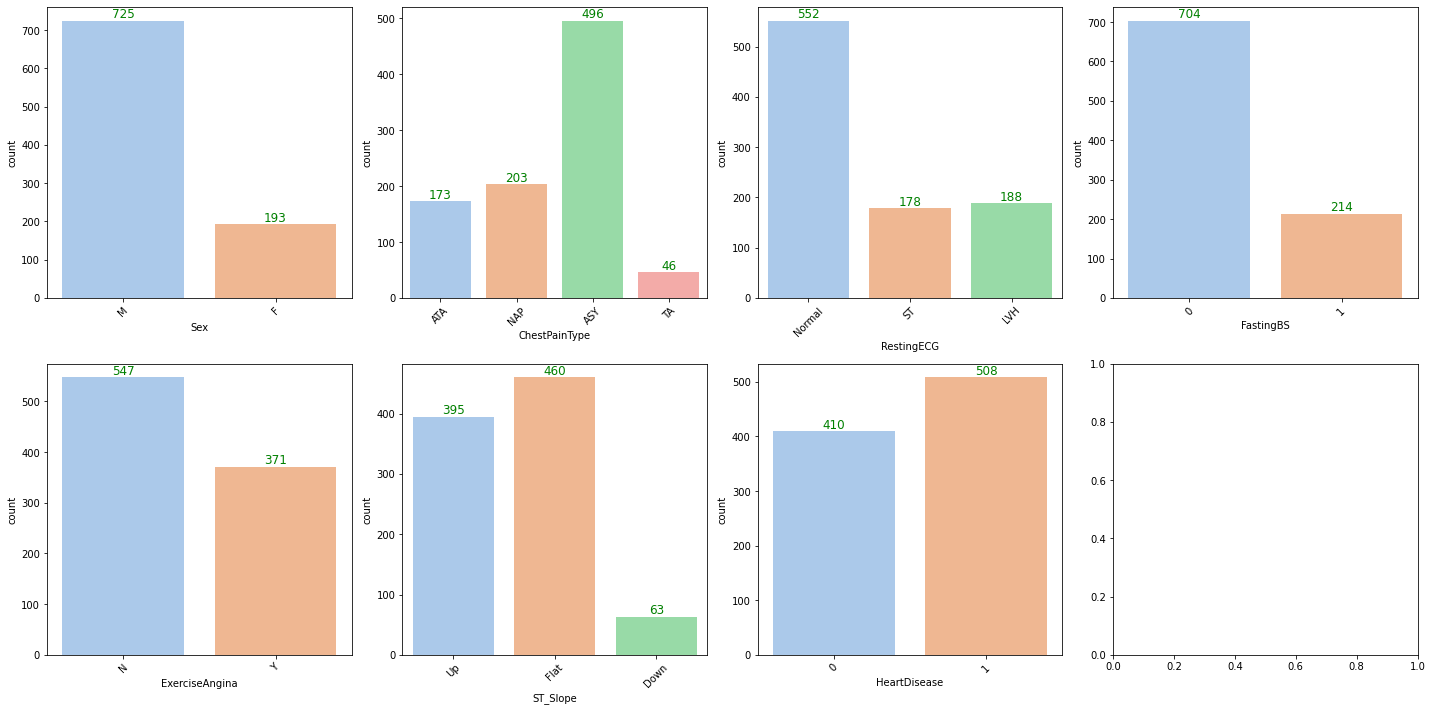

In [164]:
numerical_columns = ['age', 'avg_glucose_level', 'bmi']
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'FastingBS', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = np.ravel(axs)

for i, col in enumerate(categorical_columns):
    plt.sca(axs[i])
    countplot = sn.countplot(data=df, x=col, palette="pastel")
    for box in countplot.patches:
        plt.annotate(f"{box.get_height()}", (box.get_x()+box.get_width()/2, box.get_height()), ha='center', va='bottom', fontsize=12, color='g')

    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

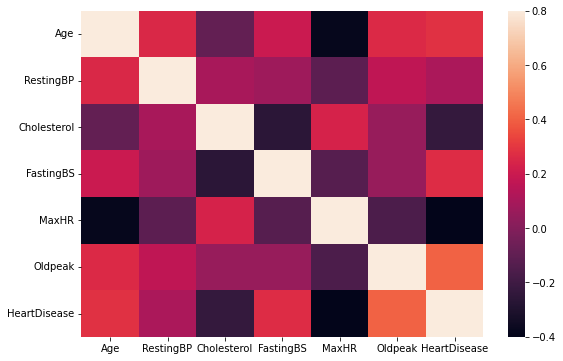

In [165]:
import seaborn as sn
# reparse the numpy matrix to df

correlation = df.corr()
_, _ = plt.subplots(figsize=(9, 6))
sn.heatmap(correlation, vmax=.8, annot=False)
plt.show()

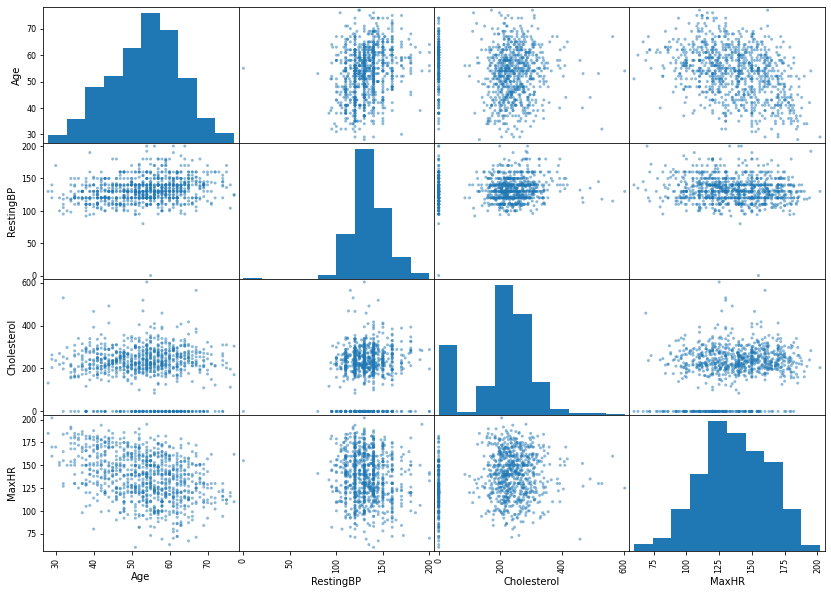

In [166]:
from pandas.plotting import scatter_matrix

# headers = list(df.columns.values)
# df_headers = pd.DataFrame(X_clean, columns=headers)
scatter_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
axs = scatter_matrix(df[scatter_columns], figsize=(14, 10))

## Analysis
- Above, we can see that there are many missing values for Cholesterol and one for age
- We need to resolve these missing values

In [167]:
print(len(df[df["Cholesterol"] == 0]))
print(len(df[df["RestingBP"] == 0]))
## since there are so many missing cholesterol, we could consider dropping the feature or just dropping the samples that are missing this feature. 
## We will test both ways to see if it affects the model

172
1


In [168]:
print(df.shape)
df_dropped_samples = df.loc[df["Cholesterol"] != 0]
df_dropped_samples = df_dropped_samples[df_dropped_samples["RestingBP"] != 0]
print(df_dropped_samples.shape)

(918, 12)
(746, 12)


In [169]:
print(df.shape)
# drop cholesterol feature entirely
df_dropped_feature = df.drop('Cholesterol', axis=1)

# only drop the sample for restingBP = 0 since it was just 1 sample
df_dropped_feature = df_dropped_feature[df_dropped_feature["RestingBP"] != 0]
print(df_dropped_feature.shape)

chol_filled = df["Cholesterol"].fillna(df['Cholesterol'].mean())
df_filled = df.copy()
df_filled["Cholesterol"] = chol_filled
df_filled = df_filled[df_filled["RestingBP"] != 0]
print(df_filled.shape)

(918, 12)
(917, 11)
(917, 12)


## Encode Categories
- First need to one-hot encode the category columns

In [170]:
def one_hot_df(df_in):
    def one_hot_col(df, column, drop=False):
        onehot = pd.get_dummies(df[column])
        new_df = pd.merge(
            left = df,
            right = onehot,
            left_index = True,
            right_index = True
        )

        if drop:
            new_df.drop(column, axis=1, inplace=True)

        return new_df
    label_column = 'HeartDisease'
    category_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ST_Slope', "ExerciseAngina"]

    for category in category_cols:
        df_in = one_hot_col(df_in, category, drop=True)

    df_in = df_in[ [ col for col in df_in.columns if col != label_column ] + [label_column]]
    return df_in


In [171]:
df_ds = one_hot_df(df_dropped_samples)
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           746 non-null    int64  
 1   RestingBP     746 non-null    int64  
 2   Cholesterol   746 non-null    int64  
 3   MaxHR         746 non-null    int64  
 4   Oldpeak       746 non-null    float64
 5   F             746 non-null    uint8  
 6   M             746 non-null    uint8  
 7   ASY           746 non-null    uint8  
 8   ATA           746 non-null    uint8  
 9   NAP           746 non-null    uint8  
 10  TA            746 non-null    uint8  
 11  0             746 non-null    uint8  
 12  1             746 non-null    uint8  
 13  LVH           746 non-null    uint8  
 14  Normal        746 non-null    uint8  
 15  ST            746 non-null    uint8  
 16  Down          746 non-null    uint8  
 17  Flat          746 non-null    uint8  
 18  Up            746 non-null    

In [172]:
df_df = one_hot_df(df_dropped_feature)
df_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           917 non-null    int64  
 1   RestingBP     917 non-null    int64  
 2   MaxHR         917 non-null    int64  
 3   Oldpeak       917 non-null    float64
 4   F             917 non-null    uint8  
 5   M             917 non-null    uint8  
 6   ASY           917 non-null    uint8  
 7   ATA           917 non-null    uint8  
 8   NAP           917 non-null    uint8  
 9   TA            917 non-null    uint8  
 10  0             917 non-null    uint8  
 11  1             917 non-null    uint8  
 12  LVH           917 non-null    uint8  
 13  Normal        917 non-null    uint8  
 14  ST            917 non-null    uint8  
 15  Down          917 non-null    uint8  
 16  Flat          917 non-null    uint8  
 17  Up            917 non-null    uint8  
 18  N             917 non-null    

In [173]:
df_filled = one_hot_df(df_filled)
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           917 non-null    int64  
 1   RestingBP     917 non-null    int64  
 2   Cholesterol   917 non-null    int64  
 3   MaxHR         917 non-null    int64  
 4   Oldpeak       917 non-null    float64
 5   F             917 non-null    uint8  
 6   M             917 non-null    uint8  
 7   ASY           917 non-null    uint8  
 8   ATA           917 non-null    uint8  
 9   NAP           917 non-null    uint8  
 10  TA            917 non-null    uint8  
 11  0             917 non-null    uint8  
 12  1             917 non-null    uint8  
 13  LVH           917 non-null    uint8  
 14  Normal        917 non-null    uint8  
 15  ST            917 non-null    uint8  
 16  Down          917 non-null    uint8  
 17  Flat          917 non-null    uint8  
 18  Up            917 non-null    

In [174]:
from sklearn.preprocessing import StandardScaler
# df_filled.head()

In [175]:
# print(len(predicted))
# df_filled_predicted[df_filled_predicted["FastingBS"].isnull()]

In [176]:
df_filled.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,F,M,ASY,ATA,NAP,...,1,LVH,Normal,ST,Down,Flat,Up,N,Y,HeartDisease
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,...,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,53.509269,132.540894,199.016358,136.789531,0.886696,0.210469,0.789531,0.540894,0.188659,0.220284,...,0.233370,0.205016,0.600872,0.194111,0.068702,0.500545,0.430752,0.595420,0.404580,0.552890
std,9.437636,17.999749,109.246330,25.467129,1.066960,0.407864,0.407864,0.498597,0.391451,0.414664,...,0.423206,0.403934,0.489986,0.395731,0.253085,0.500273,0.495452,0.491078,0.491078,0.497466
min,28.000000,80.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,174.000000,120.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,60.000000,140.000000,267.000000,156.000000,1.500000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [183]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

def clean_and_arrange(df_in, columns_to_scale=None, scale=False):
    as_matrix = df_in.to_numpy()
    num_samples, feature_length = np.size(as_matrix, 0), np.size(as_matrix, 1)
    # X = as_matrix[:,0:feature_length-1]
    X = df_in.drop(['HeartDisease'], axis=1)
    print(f'X shape: {X.shape}')
    # y = as_matrix[:,feature_length-1:feature_length]
    y = df_in['HeartDisease']
    print(f'y shape: {y.shape}')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=int(time.time()), stratify=y)
    
    if scale:
        scaler = StandardScaler()
        
        # df_in[columns_to_scale] = scaler.fit_transform(df_in[columns_to_scale])
        # scaler = StandardScaler()

        scaler.fit(X_train[columns_to_scale])
        X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
        X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
        
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    
    num_train = np.size(X_train, 0)
    num_test = np.size(X_test, 0)

    # give y_train the same shape so it can be concatenated
    y_train = np.resize(y_train, (len(y_train),1))
    # add it back to X_train as the lables
    X_train_full = np.concatenate((X_train, y_train), 1)

    # give y_test the same shape so it can be concatenated
    y_test = np.resize(y_test, (len(y_test),1))
    # add it back to X_test as the lables
    X_test_full = np.concatenate((X_test, y_test), 1)

    # recombine X, now data is organized - training data precedes the test data
    X_clean = np.concatenate((X_train_full, X_test_full), 0)

    # ensure our output has the same shape as the input
    print(f'X_clean shape: {X_clean.shape}')
    
    return pd.DataFrame(X_clean), (num_train, num_test)

In [184]:
# reform the dataframe
columns_to_scale = ['Age', 'MaxHR', 'RestingBP', 'Cholesterol', 'Oldpeak']
df_clean_ds, (num_train_ds, num_test_ds) = clean_and_arrange(df_ds, columns_to_scale=columns_to_scale, scale=True)
columns_to_scale  = ['Age', 'MaxHR', 'RestingBP', 'Oldpeak']
df_clean_df, (num_train_df, num_test_df) = clean_and_arrange(df_df, columns_to_scale=columns_to_scale, scale=True)
df_clean_filled, (num_train_filled, num_test_filled) = clean_and_arrange(df_filled)
columns_to_scale = ['Age', 'MaxHR', 'RestingBP', 'Cholesterol', 'Oldpeak']
df_clean_filled_scaled, (num_train_filled, num_test_filled) = clean_and_arrange(df_filled, columns_to_scale=columns_to_scale, scale=True)
# df_filled_predicted, (num_train_predicted, num_test_predicted) = clean_and_arrange(df_filled_predicted, True)

X shape: (746, 21)
y shape: (746,)
X_clean shape: (746, 22)
X shape: (917, 20)
y shape: (917,)
X_clean shape: (917, 21)
X shape: (917, 21)
y shape: (917,)
X_clean shape: (917, 22)
X shape: (917, 21)
y shape: (917,)
X_clean shape: (917, 22)


## Export 
- Transpose the data so each column is a sample instead of row
- Export to Csv

In [185]:
# transpose the matrix so sample is a column
df_clean = df_clean_ds.T
df_clean.to_csv('heart_cleaned_ds.csv', index = False, index_label = False, header=False)

# transpose the matrix so sample is a column
df_clean = df_clean_df.T
df_clean.to_csv('heart_cleaned_df.csv', index = False, index_label = False, header=False)

# transpose the matrix so sample is a column
df_clean = df_clean_filled.T
df_clean.to_csv('heart_cleaned_filled.csv', index = False, index_label = False, header=False)

# transpose the matrix so sample is a column
df_clean = df_clean_filled_scaled.T
df_clean.to_csv('heart_cleaned_filled_scaled.csv', index = False, index_label = False, header=False)

In [186]:
df_filled.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,F,M,ASY,ATA,NAP,...,1,LVH,Normal,ST,Down,Flat,Up,N,Y,HeartDisease
0,40,140,289,172,0.0,0,1,0,1,0,...,0,0,1,0,0,0,1,1,0,0
1,49,160,180,156,1.0,1,0,0,0,1,...,0,0,1,0,0,1,0,1,0,1
2,37,130,283,98,0.0,0,1,0,1,0,...,0,0,0,1,0,0,1,1,0,0
3,48,138,214,108,1.5,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
4,54,150,195,122,0.0,0,1,0,0,1,...,0,0,1,0,0,0,1,1,0,0


In [187]:
df_clean

,0,1,2,3,4,5,6,7,8,9,...,907,908,909,910,911,912,913,914,915,916
0,-0.803885,-0.178910,-1.637186,0.133578,1.279367,0.341903,-1.845511,0.654391,-0.178910,-0.074747,...,-0.699723,-1.220536,-0.491397,-1.428861,1.800180,0.446066,0.758554,1.383530,2.112668,1.279367
1,0.421923,-0.253215,0.421923,0.196877,-1.153400,-1.265923,-0.703308,1.547154,1.547154,0.421923,...,-1.265923,-0.703308,0.984538,-1.490969,-1.265923,-0.365738,0.084354,1.547154,0.309400,-1.265923
2,0.662611,0.478147,0.865521,0.385915,0.533486,1.216003,0.588825,-1.873770,1.179110,0.367469,...,0.662611,0.053880,0.173781,0.339799,0.570379,-1.873770,0.284460,1.667940,-1.873770,0.090772
3,1.099632,0.941757,0.507601,-0.242304,0.112914,0.231320,0.902288,0.468132,-1.702647,0.704944,...,-0.755398,1.415381,-0.597523,-2.255208,-0.281773,-1.071147,0.310257,-0.281773,-0.834335,-1.505303
4,-0.869087,-0.869087,-0.869087,0.289520,0.579172,2.027431,2.027431,-0.482885,1.544678,-0.869087,...,0.096419,-0.869087,1.061925,-0.869087,-0.869087,1.061925,1.641229,-0.869087,-0.675986,0.386071
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
